In [ ]:
'''import cv2
import glob

file_list = glob.glob('F:/data_science/Blu-Cocoon/Geotagging/Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset/data_S21C/Overlapping-NonOverlapping/1-20/*.*') #Rerurns a list of file names
print(file_list)  #Prints the list containing file names'''

In [ ]:
'''#Now let us load each file at a time...
my_list=[]  #Empty list to store images from the folder.
path = "F:/data_science/Blu-Cocoon/Geotagging/Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset/data_S21C/Overlapping-NonOverlapping/1-20/*.*"
for file in glob.glob(path):   #Iterate through each file in the list using for
    print(file)     #just stop here to see all file names printed
    a= cv2.imread(file)  #now, we can read each file since we have the full path
    my_list.append(a)  #Create a list of images (not just file names but full images)'''

In [ ]:
'''#View images from the stored list
from matplotlib import pyplot as plt
plt.imshow(my_list[2])  #View the 3rd image in the list.'''

In [ ]:
'''path2=[f for f in glob.glob(r"F:\data_science\Blu-Cocoon\Geotagging\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\data_S21C\Overlapping-NonOverlapping\1-20\*.png")]
c=[]
d=[]

for path1 in path2:
    #print(path.split("\\")[-1][4])
    if path1.split("\\")[-1][4] == "a":
        c.append(path1)
    elif path1.split("\\")[-1][4] == "b":
        d.append(path1)
    print(c)
    print(d)'''

In [ ]:
def load_images():
    img_path = 'F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\'
    imgs = []
    for file in tqdm(os.listdir(img_path)):
        imgs.append(np.array(Image.open(img_path + file)))
    # both input images are from 0-->255
    return imgs

In [ ]:
load_images()

In [ ]:
!pip install opencv-python

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import random
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import os.path
from tqdm import tqdm
import math


def load_images():
    img_path = 'F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\'
    imgs = []
    for file in tqdm(os.listdir(img_path)):
        imgs.append(np.array(Image.open(img_path + file)))
    # both input images are from 0-->255
    return imgs


def print_img(img, histo_new, histo_old, index, L):
    dpi = 80
    width = img.shape[0]
    height = img.shape[1]
    if height > width:
        figsize = (img.shape[0]*4) / float(dpi), (height)/ float(dpi)
        fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [3, 1,1]}, figsize=figsize)
    else:
        figsize = (width) / float(dpi), (height*4) / float(dpi)
        fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1,1]}, figsize=figsize)

    fig.suptitle("Enhanced Image with L:" + str(L))
    axs[0].title.set_text("Enhanced Image")
    axs[0].imshow(img, vmin=np.amin(img), vmax=np.amax(img), cmap='gray')

    axs[1].title.set_text("Equalized histogram")
    axs[1].plot(histo_new, color='#f77f00')
    axs[1].bar(np.arange(len(histo_new)), histo_new, color='#003049')

    axs[2].title.set_text("Main histogram")
    axs[2].plot(histo_old, color='#ef476f')
    axs[2].bar(np.arange(len(histo_old)), histo_old, color='#b7b7a4')
    plt.tight_layout()
    plt.savefig("e" + index + str(L)+".pdf")
    plt.savefig("e" + index + str(L)+".png")


def print_histogram(_histrogram, name, title):
    plt.figure()
    plt.title(title)
    plt.plot(_histrogram, color='#ef476f')
    plt.bar(np.arange(len(_histrogram)), _histrogram, color='#b7b7a4')
    plt.ylabel('Number of Pixels')
    plt.xlabel('Pixel Value')
    plt.savefig("hist_" + name)


def generate_histogram(img, print, index):
    if len(img.shape) == 3: # img is colorful
        gr_img = np.mean(img, axis=-1)
    else:
        gr_img = img
    '''now we calc grayscale histogram'''
    gr_hist = np.zeros([256])

    for x_pixel in range(gr_img.shape[0]):
        for y_pixel in range(gr_img.shape[1]):
            pixel_value = int(gr_img[x_pixel, y_pixel])
            gr_hist[pixel_value] += 1
    '''normalize Histogram'''
    gr_hist /= (gr_img.shape[0] * gr_img.shape[1])
    if print:
        print_histogram(gr_hist, name="neq_"+str(index), title="Normalized Histogram")
    return gr_hist, gr_img


def equalize_histogram(img, histo, L):
    eq_histo = np.zeros_like(histo)
    en_img = np.zeros_like(img)
    for i in range(len(histo)):
        eq_histo[i] = int((L - 1) * np.sum(histo[0:i]))
    print_histogram(eq_histo, name="eq_"+str(index), title="Equalized Histogram")
    '''enhance image as well:'''
    for x_pixel in range(img.shape[0]):
        for y_pixel in range(img.shape[1]):
            pixel_val = int(img[x_pixel, y_pixel])
            en_img[x_pixel, y_pixel] = eq_histo[pixel_val]
    '''creating new histogram'''
    hist_img, _ = generate_histogram(en_img, print=False, index=index)
    print_img(img=en_img, histo_new=hist_img, histo_old=histo, index=str(index), L=L)
    return eq_histo


def find_value_target(val, target_arr):
    key = np.where(target_arr == val)[0]

    if len(key) == 0:
        key = find_value_target(val+1, target_arr)
        if len(key) == 0:
            key = find_value_target(val-1, target_arr)
    vvv = key[0]
    return vvv


def match_histogram(inp_img, hist_input, e_hist_input, e_hist_target, _print=True):
    '''map from e_inp_hist to 'target_hist '''
    en_img = np.zeros_like(inp_img)
    tran_hist = np.zeros_like(e_hist_input)
    for i in range(len(e_hist_input)):
        tran_hist[i] = find_value_target(val=e_hist_input[i], target_arr=e_hist_target)
    print_histogram(tran_hist, name="trans_hist_", title="Transferred Histogram")
    '''enhance image as well:'''
    for x_pixel in range(inp_img.shape[0]):
        for y_pixel in range(inp_img.shape[1]):
            pixel_val = int(inp_img[x_pixel, y_pixel])
            en_img[x_pixel, y_pixel] = tran_hist[pixel_val]
    '''creating new histogram'''
    hist_img, _ = generate_histogram(en_img, print=False, index=3)
    print_img(img=en_img, histo_new=hist_img, histo_old=hist_input, index=str(3), L=L)


if __name__ == '__main__':
    L=50
    print("\r\nLoading Images:")
    imgs = load_images()
    print("\r\ngenerating HistogramS:")
    gr_img_arr = []
    gr_hist_arr = []
    eq_hist_arr = []
    index = 0
    for img in tqdm(imgs):
        hist_img, gr_img = generate_histogram(img, print=True, index=index)
        gr_hist_arr.append(hist_img)
        gr_img_arr.append(gr_img)
        eq_hist_arr.append(equalize_histogram(gr_img, hist_img, L))
        index += 1
    match_histogram(inp_img=gr_img_arr[0], hist_input=gr_hist_arr[0], e_hist_input=eq_hist_arr[0], e_hist_target=eq_hist_arr[1])

In [ ]:
'''import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20a11.png',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()'''

In [ ]:
'''import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20a1.png',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()'''

In [ ]:
#plt.hist(img.ravel(), bins=256, range=(0.0, 5.0), fc='k', ec='k') #calculating histogram

In [ ]:
#plt.hist(img.ravel(), bins=256, range=(10.0, 25.0), fc='k', ec='k') #calculating histogram

In [ ]:
#plt.hist(img.ravel(), bins=256, range=(26.0, 50.0), fc='k', ec='k') #calculating histogram

In [ ]:
#plt.hist(img.ravel(), bins=256, range=(51.0, 100.0), fc='k', ec='k') #calculating histogram

In [ ]:
#plt.hist(img.ravel(), bins=256, range=(101.0, 255.0), fc='k', ec='k') #calculating histogram

In [ ]:
#plt.hist(img.ravel(), bins=256, range=(0.0, 255.0), fc='k', ec='k') #calculating histogram

In [ ]:
# Canny edge detection based on lower and upper thresholding
def edge_detection(img, lower_th = None, upper_th = None):
             
    # Noise reduction step
    img = cv.GaussianBlur(img, (5, 5), 1.4)
    
    # Calculating the gradients
    gx = cv.Sobel(np.float32(img), cv.CV_64F, 1, 0, 3)
    gy = cv.Sobel(np.float32(img), cv.CV_64F, 0, 1, 3)
      
    # Conversion of Cartesian coordinates to polar 
    mag, ang = cv.cartToPolar(gx, gy, angleInDegrees = True)
       
    # set the minimum and maximum thresholds as lower and upper 
    mag_max = np.max(mag)
    if not lower_th:lower_th = mag_max * 0.1
    if not upper_th:upper_th = mag_max * 0.5
      
    # getting the dimensions of the input image  
    height, width = img.shape
       
    # Looping through every pixel of the grayscale 
    # image
    for i_x in range(width):
        for i_y in range(height):
               
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
               
            # selecting the neighbours of the target pixel according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
              
            # top right (diagnol-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagnol-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
               
            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0
   
    lower_ids = np.zeros_like(img)
    upper_ids = np.zeros_like(img)              
    ids = np.zeros_like(img)
       
    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
              
            grad_mag = mag[i_y, i_x]
              
            if grad_mag < lower_th:
                mag[i_y, i_x]= 0
            elif upper_th > grad_mag>= lower_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2
           
    # returning the magnitude of gradients of edges
    return mag

In [ ]:
# Finding edges of image
import cv2 as cv
#original_image_path=
gray_img = cv.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20b31.png',0)
enh_img_hst = cv.equalizeHist(gray_img)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enh_img_clahe = clahe.apply(gray_img)
canny_gray_img = edge_detection(gray_img)
canny_img_hist = edge_detection(enh_img_hst)
canny_img_clahe = edge_detection(enh_img_clahe)

edge_res_img = [canny_gray_img, canny_img_hist, canny_img_clahe]
edge_img_title = ['Input Image', 'Histogram Equalized', 'Enhanced Histogram Equalized']

#plt.imshow(canny_img_clahe, cmap='gray')

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 1
columns = 3

for idx in range(columns):
    fig.add_subplot(rows, columns, idx+1)
    plt.imshow(edge_res_img[idx], cmap='gray')
    plt.axis('off')
    plt.title(edge_img_title[idx])

In [ ]:
'''from PIL import Image

img = Image.open('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20a1.png')
imgWidth, imgHeight = img.size
img = img.convert("RGBA")
imgdata = img.getdata()

x_pos = 0
y_pos = 1

pixel_value = []
x = []
y = []

for item in imgdata:
    if (x_pos) == imgWidth:
        x_pos = 1
        y_pos += 1
    else:
        x_pos += 1

    if item[3] != 0:
        pixel_value.append(item[2])
        x.append(x_pos)
        y.append(y_pos)

pixel_value, x, y = zip(*sorted(zip(pixel_value, x, y), reverse=True))

print(f'{pixel_value}\n{x}\n{y}')'''

In [ ]:
#--NotebookApp.iopub_data_rate_limit=1.0e10

In [ ]:
img = cv2.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20a1.png',cv.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(img, 0, 255,cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU)
plt.figure(figsize=(8,8))
plt.imshow(thresh,cmap="gray")
plt.axis('off')
plt.title("Threshold Image")
plt.show()

In [ ]:
kernel = np.ones((3, 3), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE,kernel, iterations = 15)
bg = cv2.dilate(closing, kernel, iterations = 1)
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 0)
ret, fg = cv2.threshold(dist_transform, 0.02*dist_transform.max(), 255, 0)
cv2.imshow('image', fg)
plt.figure(figsize=(8,8))
plt.imshow(fg,cmap="gray")
plt.axis('off')
plt.title("Segmented Image")
plt.show()

In [ ]:
'''#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

# Image segmentation and morphological operators

from matplotlib import pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu
import cv2


img = cv2.imread("F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\img_a1.png")

#Denoise for better results
from skimage.restoration import denoise_tv_chambolle
denoised_img = denoise_tv_chambolle(img, weight=0.1, eps=0.0002, n_iter_max=200, multichannel=False)
plt.imshow(denoised_img, cmap='gray')
plt.hist(img.flat, bins=100, range=(100,255))  #.flat returns the flattened numpy array (1D)'''

In [ ]:
'''##################MANUAL########################
#Can perform manual segmentation but auto works fine
region1 = (img >= 0) & (img <75)
region2 = (img >= 75) & (img <140)
region3 = (img >= 140) & (img <200)
region4 = (img >= 200) & (img <=255)
all_regions = np.zeros((img.shape[0], img.shape[1], 3)) #Create 3 channel blank image of same size as original
all_regions[region1] = (1,0,0)
all_regions[region2] = (0,1,0)
all_regions[region3] = (0,0,1)
all_regions[region4] = (1,1,0)
plt.imshow(all_regions)
##############################################
####AUTO###########################
# Apply multi-Otsu threshold 
thresholds = threshold_multiotsu(img, classes=4)

# Digitize (segment) original image into multiple classes.
#np.digitize assign values 0, 1, 2, 3, ... to pixels in each class.
regions = np.digitize(img, bins=thresholds)
plt.imshow(regions)

segm1 = (regions == 0)
segm2 = (regions == 1)
segm3 = (regions == 2)
segm4 = (regions == 3)


#We can use binary opening and closing operations to clean up. 
#Open takes care of isolated pixels within the window
#Closing takes care of isolated holes within the defined window

from scipy import ndimage as nd

segm1_opened = nd.binary_opening(segm1, np.ones((3,3)))
segm1_closed = nd.binary_closing(segm1_opened, np.ones((3,3)))

segm2_opened = nd.binary_opening(segm2, np.ones((3,3)))
segm2_closed = nd.binary_closing(segm2_opened, np.ones((3,3)))

segm3_opened = nd.binary_opening(segm3, np.ones((3,3)))
segm3_closed = nd.binary_closing(segm3_opened, np.ones((3,3)))

segm4_opened = nd.binary_opening(segm4, np.ones((3,3)))
segm4_closed = nd.binary_closing(segm4_opened, np.ones((3,3)))

all_segments_cleaned = np.zeros((img.shape[0], img.shape[1], 3)) 

all_segments_cleaned[segm1_closed] = (1,0,0)
all_segments_cleaned[segm2_closed] = (0,1,0)
all_segments_cleaned[segm3_closed] = (0,0,1)
all_segments_cleaned[segm4_closed] = (1,1,0)

plt.imshow(all_segments_cleaned)  #All the noise should be cleaned now
#plt.imsave("images/BSE_segmented.jpg", all_segments_cleaned)'''

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# read the image
image = cv2.imread("F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20a11.png")

In [ ]:
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

In [ ]:
print(pixel_values.shape)

In [ ]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [ ]:
# number of clusters (K)
k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [ ]:
# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

In [ ]:
# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

In [ ]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

In [ ]:
# disable only the cluster number 2 (turn the pixel into black)
masked_image = np.copy(image)
# convert to the shape of a vector of pixel values
masked_image = masked_image.reshape((-1, 3))
# color (i.e cluster) to disable
cluster = 2
masked_image[labels == cluster] = [0, 0, 0]
# convert back to original shape
masked_image = masked_image.reshape(image.shape)
# show the image
plt.imshow(masked_image)
plt.show()

In [ ]:
from skimage.filters import sobel

elevation_map = sobel(image)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('elevation_map')

In [ ]:
'''arr=image.flatten()
for i in range(len(arr)):
    if arr[i]>=arr.mean() :
        arr[i]=1
    else:
        arr[i]=0
gray_segmented=arr.reshape(gray.shape[0],gray.shape[1])'''

In [5]:
from skimage.color import rgb2gray
import skimage.segmentation
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from PIL import Image
from sklearn.cluster import KMeans
from skimage.filters import sobel
import skimage
import warnings
warnings.filterwarnings("ignore")

In [6]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from PIL import Image
from sklearn.cluster import KMeans
from skimage.filters import sobel
import skimage
import warnings
warnings.filterwarnings("ignore")

In [ ]:
'''image=Image.open("F:\data_science\Blu-Cocoon\Geotagging\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\data_S21C\Overlapping-NonOverlapping\enh_img_hst\\1-20a11.png")
image=image.resize((320,225))
image=np.array(image)
plt.imshow(image)'''

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# read the image
image = cv2.imread("F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\enh_img_hst\\1-20a11.png")
image=np.array(image)

In [11]:
arr=image.flatten()
for i in range(len(arr)):
    if arr[i]>=arr.mean():
        arr[i]=1
    else:
        arr[i]=0
gray_segmented=arr.reshape(image.shape[0],image.shape[1])

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [12]:
imm=image[:,:,0]
elevation_map = sobel(imm)

fig, ax = plt.subplots(figsize=(18,8))
ax.imshow(elevation_map, cmap='gray', interpolation='nearest')
ax.axis('off')
ax.set_title('elevation_map')
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 3 were indexed

In [ ]:
plt.hist(imm.flatten())
plt.show()

In [ ]:
markers = np.zeros_like(imm)
markers[imm < 117] = 1
markers[imm > 232] = 2

fig, ax = plt.subplots(figsize=(8,4))
ax.imshow(markers, cmap='Spectral', interpolation='nearest')
ax.axis('off')
ax.set_title('markers')

In [ ]:
segmentation = skimage.segmentation.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(10,5))
ax.imshow(segmentation, cmap='pink',interpolation='nearest')
ax.axis('off')
ax.set_title('segmentation')

In [ ]:
from skimage.color import label2rgb

segmentation = ndimage.binary_fill_holes(segmentation - 1)
labeled_mountains, _ = ndimage.label(segmentation)
image_label_overlay = label2rgb(labeled_mountains, image=imm)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
ax1.imshow(imm, cmap=plt.cm.gray, interpolation='nearest')
ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax1.axis('off')
ax1.set_adjustable('box')
ax2.imshow(image_label_overlay, interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box')

In [9]:
from skimage.color import rgb2gray
import skimage.segmentation
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from PIL import Image
from sklearn.cluster import KMeans
from skimage.filters import sobel
import skimage
import warnings
warnings.filterwarnings("ignore")

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# read the image
image = cv2.imread("F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20a11.png")

In [11]:
im=image/255
pic=im.reshape(im.shape[0]*im.shape[1],im.shape[2])

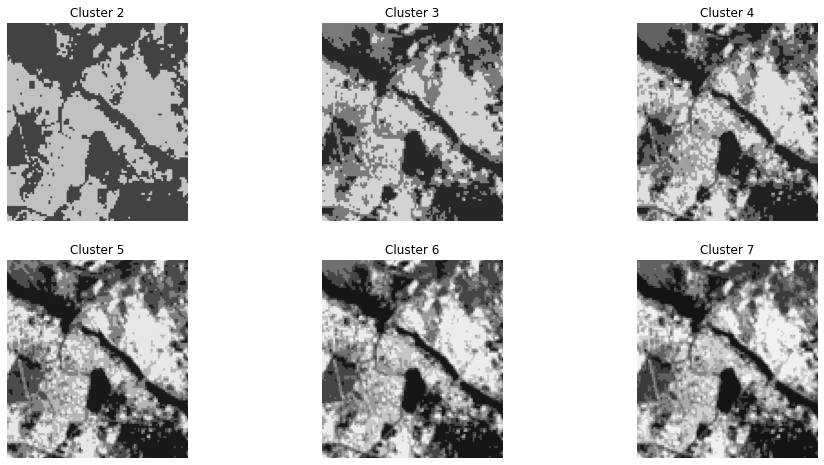

<Figure size 432x288 with 0 Axes>

In [12]:
# Since we know 5 segments was looking great on the image we are gonna do 5 clusters here but you can try more too :)
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
count=1
clustered_image=[]
for i in range(2):
    for j in range(3):

        kmeans = KMeans(n_clusters=count+1, random_state=0).fit(pic)
        pic_print = kmeans.cluster_centers_[kmeans.labels_]
        clustered_pic=pic_print.reshape(im.shape[0],im.shape[1],im.shape[2])
        clustered_image.append(clustered_pic)
        count+=1
        ax[i][j].set_title('Cluster '+str(count))
        ax[i][j].imshow(clustered_pic)
        ax[i][j].set_axis_off()
plt.show()
plt.savefig('cluster.png', dpi=300, bbox_inches='tight')

In [17]:
len(clustered_image)

6

In [18]:
len(clustered_image[3])

660

In [19]:
clustered_image[3].shape

(660, 601, 3)

In [20]:
clustered_image[3]

array([[[0.50639066, 0.50639066, 0.50639066],
        [0.50639066, 0.50639066, 0.50639066],
        [0.50639066, 0.50639066, 0.50639066],
        ...,
        [0.09843149, 0.09843149, 0.09843149],
        [0.09843149, 0.09843149, 0.09843149],
        [0.30108773, 0.30108773, 0.30108773]],

       [[0.50639066, 0.50639066, 0.50639066],
        [0.50639066, 0.50639066, 0.50639066],
        [0.50639066, 0.50639066, 0.50639066],
        ...,
        [0.09843149, 0.09843149, 0.09843149],
        [0.09843149, 0.09843149, 0.09843149],
        [0.30108773, 0.30108773, 0.30108773]],

       [[0.50639066, 0.50639066, 0.50639066],
        [0.50639066, 0.50639066, 0.50639066],
        [0.50639066, 0.50639066, 0.50639066],
        ...,
        [0.09843149, 0.09843149, 0.09843149],
        [0.09843149, 0.09843149, 0.09843149],
        [0.30108773, 0.30108773, 0.30108773]],

       ...,

       [[0.90674314, 0.90674314, 0.90674314],
        [0.90674314, 0.90674314, 0.90674314],
        [0.90674314, 0

In [16]:
for i in clustered_image[3]:
    print(i.mean())
    #plt.imshow(i.mean)       

0.45714403666415654
0.46498051713780036
0.4531358934085788
0.4486547513318802
0.44831314912722975
0.44831314912722975
0.44831314912722975
0.45036276235513245
0.4223976499387681
0.4222496603951418
0.42473883509137944
0.42608762870937633
0.42608762870937633
0.428137241937279
0.41783633019595073
0.3967641949902705
0.41012326980261116
0.4093993555315918
0.41007815614074145
0.41007815614074145
0.40461252086633426
0.37808949687807053
0.3753221280545388
0.38196168786777196
0.37801259076144406
0.37801259076144406
0.37801259076144406
0.3654569813922509
0.36593313169155905
0.37190846829413
0.3799259652552046
0.3799259652552046
0.3795843630505542
0.37377712557149656
0.37378085015676615
0.3816737241558877
0.3736425819304499
0.36688690826541887
0.36688690826541887
0.36688690826541887
0.36615966585460563
0.3707637933929479
0.3544725787733559
0.33621249143441656
0.3341628782065139
0.3341628782065139
0.33009007455161593
0.3341547498210931
0.34635690401494545
0.35455095312640494
0.3527616360557855
0.35

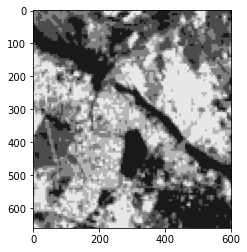

In [17]:
plt.imshow(clustered_image[3])

In [ ]:
'''for i in range(0,clustered_image.shape[0]):
    for j in range(0,clustered_image.shape[1]):
        feature_matrix[i][j] = ((int(image[i,j,0]) + int(image[i,j,1]) + int(image[i,j,2]))/3)'''

In [ ]:
'''import math 

from PIL import Image
from pylab import *
import matplotlib.cm as cm
import scipy as sp
import random

im = Image.open('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20a1.png').convert('L')
arr = np.asarray(im)

#out = Image.open('out1.jpg').convert('L')
#arr_out = np.asarray(out)

rows,columns = np.shape(arr)
#print '\nrows',rows,'columns',columns
plt.figure()
plt.imshow(im)
plt.gray()
#User selects the intial seed point
print ('\nPlease select the initial seed point')

pseed = plt.ginput(1)
#pseed
#print pseed[0][0],pseed[0][1]

x = int(pseed[0][0])
y = int(pseed[0][1])
#x = int(179)
#y = int(86)
seed_pixel = []
seed_pixel.append(x)
seed_pixel.append(y)

print ('you clicked:',seed_pixel)

#closing figure
plt.close()

img_rg = np.zeros((rows+1,columns+1))
img_rg[seed_pixel[0]][seed_pixel[1]] = 255.0
img_display = np.zeros((rows,columns))

region_points = []
region_points.append([x,y])

def find_region():
	print ('\nloop runs till region growing is complete')
	#print 'starting points',i,j
	count = 0
	x = [-1, 0, 1, -1, 1, -1, 0, 1]
	y = [-1, -1, -1, 0, 0, 1, 1, 1]
	
	while( len(region_points)>0):
		
		if count == 0:
			point = region_points.pop(0)
			i = point[0]
			j = point[1]
		print ('\nloop runs till length become zero:')
		print ('len',len(region_points))
		#print 'count',count 
		val = arr[i][j]
		lt = val - 8
		ht = val + 8
		#print 'value of pixel',val
		for k in range(8):	
			#print '\ncomparison val:',val, 'ht',ht,'lt',lt
			if img_rg[i+x[k]][j+y[k]] !=1:
				try:
					if  arr[i+x[k]][j+y[k]] > lt and arr[i+x[k]][j+y[k]] < ht:
						#print '\nbelongs to region',arr[i+x[k]][j+y[k]]
						img_rg[i+x[k]][j+y[k]]=1
						p = [0,0]
						p[0] = i+x[k]
						p[1] = j+y[k]
						if p not in region_points: 
							if 0< p[0] < rows and 0< p[1] < columns:
								''' adding points to the region '''
								region_points.append([i+x[k],j+y[k]])
					else:
						#print 'not part of region'
						img_rg[i+x[k]][j+y[k]]=0
				except IndexError:     
                			continue

		#print '\npoints list',region_points
		point = region_points.pop(0)
		i = point[0]
		j = point[1]
		count = count +1
		#find_region(point[0], point[1])			 
		
find_region()

ground_out = np.zeros((rows,columns))

for i in range(rows):
	for j in range(columns):
		if arr_out[i][j] >125:
			ground_out[i][j] = int(1)

		else:
			ground_out[i][j] = int(0)


tp = 0
tn = 0
fn = 0
fp = 0

for i in range(rows):
	for j in range(columns):
		if ground_out[i][j] == 1 and img_rg[i][j] == 1:
			tp = tp + 1
		if ground_out[i][j] == 0 and img_rg[i][j] == 0:
			tn = tn + 1
		if ground_out[i][j] == 1 and img_rg[i][j] == 0:
			fn = fn + 1
		if ground_out[i][j] == 0 and img_rg[i][j] == 1:
			fp = fp + 1
''' ********************************** Calculation of Tpr, Fpr, F-Score ***************************************************'''

print ('\n************Calculation of Tpr, Fpr, F-Score********************')

#TP rate = TP/TP+FN
tpr= float(tp)/(tp+fn)
print ("\nTPR is:",tpr)

#fp rate is
fpr= float(fp)/(fp+tn)
print ("\nFPR is:",fpr)

#F-score as 2TP/(2TP + FP + FN)
fscore = float(2*tp)/((2*tp)+fp+fn)
print ("\nFscore:",fscore)


plt.figure()
plt.imshow(img_rg, cmap="Greys_r")
plt.colorbar()
plt.show()'''

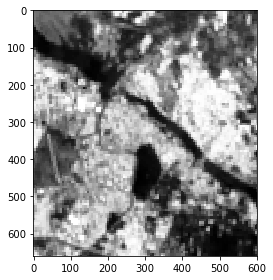

In [22]:
from skimage import data, io, filters
import matplotlib.pyplot as plt
#image = data.coins()
io.imshow(image)

In [18]:
#first, let's convert to 1-dim vector the image, so that we can have #all the pixels value and compare each and every value to the #threshold
flat_pixels = image.reshape(image.shape[0]*image.shape[1])
threshold = flat_pixels.mean()
for i in range(flat_pixels.shape[0]):
    if flat_pixels[i] > threshold:
        flat_pixels[i] = 1
    else:
        flat_pixels[i] = 0
#let's reshape the 1-dim vector back to the original image size
seg_image = flat_pixels.reshape(image.shape[0],image.shape[1])
plt.imshow(seg_image)

ValueError: cannot reshape array of size 1189980 into shape (396660,)

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(image)
clustered = kmeans.cluster_centers_[kmeans.labels_]
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.imshow(clustered)
plt.axis('off')
plt.subplot(122)
plt.imshow(image)
plt.axis('off')

ValueError: Found array with dim 3. Estimator expected <= 2.

In [25]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20a1.png',cv.IMREAD_GRAYSCALE)
#gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(img,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [26]:
print(cv2.__version__)

4.5.3


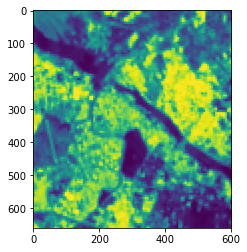

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import time

%matplotlib inline

PATH = "F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20a11.png"

for i in range(1,4):
    p = PATH.format(i)
    #print p
    image = mpimg.imread(p) # images are color images
    plt.gca().clear()
    plt.imshow(image);
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0) # wait one second

In [31]:
from skimage.io import imread, imshow
#image = imread('https://d1m75rqqgidzqn.cloudfront.net/content/pexels-photo-1108099.jpeg', as_gray=True) 
img.shape, imshow(img)

AttributeError: 'NoneType' object has no attribute 'shape'

In [32]:
#check the image shape 
print(image.shape) 
 
print(image)

(660, 601)
[[0.43137255 0.43137255 0.43137255 ... 0.14117648 0.14117648 0.21960784]
 [0.43137255 0.43137255 0.43137255 ... 0.14117648 0.14117648 0.21960784]
 [0.43137255 0.43137255 0.43137255 ... 0.14117648 0.14117648 0.21960784]
 ...
 [1.         1.         1.         ... 0.10588235 0.10588235 0.10588235]
 [1.         1.         1.         ... 0.10588235 0.10588235 0.10588235]
 [1.         1.         1.         ... 0.10588235 0.10588235 0.10588235]]


In [33]:
image.shape

(660, 601)

In [34]:
feature_matrix_image = np.zeros((375,500)) 
feature_matrix_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
for i in range(0,image.shape[0]):
 
    for j in range(0,image.shape[1]):
 
        feature_matrix_image[i][j] = ((int(image[i,j,0]) + int(image[i,j,1]) + int(image[i,j,2]))/3)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [36]:
ret,thresh_binary = cv2.threshold(segmented_image,127,255,cv2.THRESH_BINARY)
 
ret,thresh_binary_inv = cv2.threshold(segmented_image,127,255,cv2.THRESH_BINARY_INV)
 
ret,thresh_trunc = cv2.threshold(segmented_image,127,255,cv2.THRESH_TRUNC)
 
ret,thresh_tozero = cv2.threshold(segmented_image,127,255,cv2.THRESH_TOZERO)
 
ret,thresh_tozero_inv = cv2.threshold(segmented_image,127,255,cv2.THRESH_TOZERO_INV)
#DISPLAYING THE DIFFERENT THRESHOLDING STYLES using OpenCV
 
names = ['Oiriginal Image','BINARY','THRESH_BINARY','THRESH_TRUNC','THRESH_TOZERO','THRESH_TOZERO_INV']
 
images = segmented_image,thresh_binary,thresh_binary_inv,thresh_trunc,thresh_tozero,thresh_tozero_inv
 
for i in range(6):
 
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
 
    plt.title(names[i])
 
    plt.xticks([]),plt.yticks([])

NameError: name 'segmented_image' is not defined

In [19]:
# example of pixel normalization
from numpy import asarray
from PIL import Image
# load image
image = Image.open('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20b11.png')
pixels = asarray(image)
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 2.000, Max: 255.000
Min: 0.008, Max: 1.000


In [20]:
mean = pixels.mean()

In [21]:
mean

0.33690488

In [22]:
print('Mean: %.3f' % mean)

Mean: 0.337


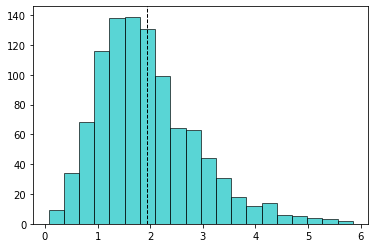

In [23]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(6789)
x = np.random.gamma(4, 0.5, 1000)
result = plt.hist(x, bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)

Text(2.140131222101623, 131.355, 'Mean: 1.95')

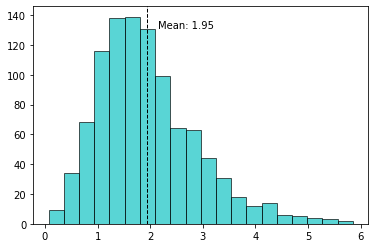

In [24]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(6789)
x = np.random.gamma(4, 0.5, 1000)
result = plt.hist(x, bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))

Text(2.140131222101623, 131.355, 'Mean: 1.95')

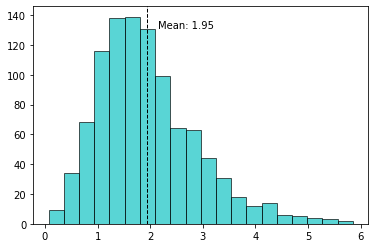

In [25]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(6789)
x = np.random.gamma(4, 0.5, 1000)
result = plt.hist(x, bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))

In [26]:
np.mean(image)

85.91073211314476

In [28]:
import cv2
import numpy
myimg = cv2.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20b11.png')
avg_color_per_row = numpy.mean(myimg, axis=0)
avg_color = numpy.mean(avg_color_per_row, axis=0)
print(avg_color)
print(avg_color_per_row)

[85.91073211 85.91073211 85.91073211]
[[104.61515152 104.61515152 104.61515152]
 [103.85       103.85       103.85      ]
 [103.03030303 103.03030303 103.03030303]
 ...
 [ 73.58939394  73.58939394  73.58939394]
 [ 76.44545455  76.44545455  76.44545455]
 [ 76.95606061  76.95606061  76.95606061]]


In [29]:
import cv2
import numpy
#myimg_clustered = cv2.imread(clustered_image[3])
avg_color_per_row_clustered = numpy.mean(clustered_image[3], axis=0)
avg_color_clustered = numpy.mean(clustered_image[3])
print(avg_color_clustered)
print(avg_color_per_row_clustered)

0.5062853948113859
[[0.62409754 0.62409754 0.62409754]
 [0.61811152 0.61811152 0.61811152]
 [0.61439319 0.61439319 0.61439319]
 ...
 [0.41871932 0.41871932 0.41871932]
 [0.43802175 0.43802175 0.43802175]
 [0.43956104 0.43956104 0.43956104]]


In [43]:
import cv2, numpy as np
from sklearn.cluster import KMeans

def visualize_colors(cluster, centroids):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    start = 0
    for (percent, color) in colors:
        print(color, "{:0.2f}%".format(percent * 100))
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
    return rect

# Load image and convert to a list of pixels
image = clustered_image[3]
#image = cv2.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20a1.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
reshape = image.reshape((image.shape[0] * image.shape[1], 3))

# Find and display most dominant colors
cluster = KMeans(n_clusters=4).fit(reshape)
visualize = visualize_colors(cluster, cluster.cluster_centers_)
visualize = cv2.cvtColor(visualize, cv2.COLOR_RGB2BGR)
cv2.imshow('visualize', visualize)
cv2.waitKey()

[0.09843149 0.09843149 0.09843149] 18.98%
[0.30108773 0.30108773 0.30108773] 20.23%
[0.50639066 0.50639066 0.50639066] 21.51%
[0.80891449 0.80891449 0.80891449] 39.28%


-1

In [ ]:
import cv2, numpy as np
from sklearn.cluster import KMeans

def visualize_colors(cluster, centroids):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    start = 0
    for (percent, color) in colors:
        print(color, "{:0.2f}%".format(percent * 100))
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
    return rect

# Load image and convert to a list of pixels
image = clustered_image[3]
#image = cv2.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20a1.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
reshape = image.reshape((image.shape[0] * image.shape[1], 3))

# Find and display most dominant colors
cluster = KMeans(n_clusters=4).fit(reshape)
visualize = visualize_colors(cluster, cluster.cluster_centers_)
visualize = cv2.cvtColor(visualize, cv2.COLOR_RGB2BGR)
cv2.imshow('visualize', visualize)
cv2.waitKey()

In [ ]:
import cv2, numpy as np
from sklearn.cluster import KMeans

def visualize_colors(cluster, centroids):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    start = 0
    for (percent, color) in colors:
        print(color, "{:0.2f}%".format(percent * 100))
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
    return rect

# Load image and convert to a list of pixels
#image = clustered_image[3]
image = cv2.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\data_S21C\\Overlapping-NonOverlapping\\1-20\\1-20a1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
reshape = image.reshape((image.shape[0] * image.shape[1], 3))

# Find and display most dominant colors
cluster = KMeans(n_clusters=4).fit(reshape)
visualize = visualize_colors(cluster, cluster.cluster_centers_)
visualize = cv2.cvtColor(visualize, cv2.COLOR_RGB2BGR)
cv2.imshow('visualize', visualize)
cv2.waitKey()

In [47]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import sys




def on_mouse(event, x, y, flags, params):
    if event == cv.CV_EVENT_LBUTTONDOWN:
        print ('Start Mouse Position: ' + str(x) + ', ' + str(y))
        s_box = x, y
        boxes.append(s_box)





def region_growing(img, seed):
    #Parameters for region growing
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    region_threshold = 0.2
    region_size = 1
    intensity_difference = 0
    neighbor_points_list = []
    neighbor_intensity_list = []

    #Mean of the segmented region
    region_mean = img[seed]

    #Input image parameters
    height, width = img.shape
    image_size = height * width

    #Initialize segmented output image
    segmented_img = np.zeros((height, width, 1), np.uint8)

    #Region growing until intensity difference becomes greater than certain threshold
    while (intensity_difference < region_threshold) & (region_size < image_size):
        #Loop through neighbor pixels
        for i in range(4):
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]

            #Boundary Condition - check if the coordinates are inside the image
            check_inside = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)

            #Add neighbor if inside and not already in segmented_img
            if check_inside:
                if segmented_img[x_new, y_new] == 0:
                    neighbor_points_list.append([x_new, y_new])
                    neighbor_intensity_list.append(img[x_new, y_new])
                    segmented_img[x_new, y_new] = 255

        #Add pixel with intensity nearest to the mean to the region
        distance = abs(neighbor_intensity_list-region_mean)
        pixel_distance = min(distance)
        index = np.where(distance == pixel_distance)[0][0]
        segmented_img[seed[0], seed[1]] = 255
        region_size += 1

        #New region mean
        region_mean = (region_mean*region_size + neighbor_intensity_list[index])/(region_size+1)

        #Update the seed value
        seed = neighbor_points_list[index]
        #Remove the value from the neighborhood lists
        neighbor_intensity_list[index] = neighbor_intensity_list[-1]
        neighbor_points_list[index] = neighbor_points_list[-1]

    return segmented_img


if __name__ == '__main__':

    boxes = []
    filename = ('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20a11.png')
    img = cv2.imread(filename, 0)
    resized = cv2.resize(img,(256,256))
    cv2.namedWindow('input')
    cv2.setMouseCallback('input', on_mouse, 0,)
    cv2.imshow('input', resized)
    cv2.waitKey()
    print ("Starting region growing based on last click")
    seed = boxes[-1]
    cv2.imshow('input', region_growing(resized, seed))
    print ("Done. Showing output now")

    cv2.waitKey()
    cv2.destroyAllWindows()

Starting region growing based on last click


IndexError: list index out of range